## Processing and analyzing text

Import all the necessary libraries:

In [1]:
import requests
from bs4 import BeautifulSoup

from io import BytesIO
import scrapy
from scrapy.crawler import CrawlerProcess
import pdfplumber

import logging
logging.disable(logging.CRITICAL)

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import yake
import spacy

from wordcloud import WordCloud
import matplotlib.pyplot as plt

Send test requests to make sure that resource is reachable:

In [2]:
def test_request(url):
    data = requests.get(url, timeout=5)
    data.raise_for_status()
    return(data)


urls = ['https://scholar.google.com/scholar?start=0&q=cryptography&hl=en&as_sdt=0,5',
        'https://scholar.google.com/scholar?start=10&q=cryptography&hl=en&as_sdt=0,5',
        'https://scholar.google.com/scholar?start=20&q=cryptography&hl=en&as_sdt=0,5',
        'https://scholar.google.com/scholar?start=30&q=cryptography&hl=en&as_sdt=0,5']

for url in urls:
    print(test_request(url))

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


Create scraping class with parsing function:

In [3]:
class ArticleSpider(scrapy.Spider):
    name = 'article'

    
    def start_requests(self):
        return [scrapy.Request(url=url, callback=self.parse) for url in urls]

    
    def parse(self, response):
        bs = BeautifulSoup(response.text, 'html.parser')
        articles = bs.find_all('div', {'class': 'gs_r gs_or gs_scl'})

        counter = 0
        for article in articles:
            type = article.find('span', {'class': 'gs_ct1'})
            if (type == None or type.text != '[BOOK]'):
                article_link = article.find('a')['href']
                
                print(article_link)
                if (article_link[-4:] != '.pdf'):
                    continue
                try:
                    article_data = test_request(article_link)
                except requests.exceptions.RequestException:
                    continue
                
                print("Extracting...")
                counter += 1

                with pdfplumber.open(BytesIO(article_data.content)) as pdf:
                    page_number = 0
                    with open(f'article{counter}.txt', 'w', encoding='utf-8') as file:
                        for page in pdf.pages:
                            page_number += 1
                            file.write(page.extract_text() + '\n')
                            print(page_number)
                print("OK")

Start scraping process:

In [4]:
process = CrawlerProcess()
process.crawl(ArticleSpider)
process.start()

https://www.academia.edu/download/38411944/An_Overview_of_Cryptography.pdf
https://dl.acm.org/doi/pdf/10.1145/103418.103474
https://caislab.kaist.ac.kr/lecture/2010/spring/cs548/basic/B08.pdf
Extracting...
1
2
3
4
5
6
7
8
9
10
11
OK
https://arxiv.org/pdf/quant-ph/0101098
https://www.sciencedirect.com/science/article/pii/B9780444880710500187
http://molphys.ustu.ru/%D0%9A%D0%9C%D0%97%D0%98/%D0%9B%D0%B8%D1%82%D0%B5%D1%80%D0%B0%D1%82%D1%83%D1%80%D0%B0/%D0%90.%20Salomaa.%20%D0%9A%D1%80%D0%B8%D0%BF%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D1%84%D0%B8%D1%8F%20%D1%81%20%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%BC%20%D0%BA%D0%BB%D1%8E%D1%87%D0%BE%D0%BC.%20%D0%9C.%20%D0%9C%D0%B8%D1%80.%201999%D0%B3.%20318%D1%81.pdf
Extracting...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96

Extract keywords from article:

In [8]:
keywords = []

stop_words_english = set(stopwords.words('english'))
stop_words_russian = set(stopwords.words('russian'))
stop_words = list(stop_words_english.union(stop_words_russian))


def pre_process_keywords(text):
    text = text.lower()
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
    text = re.sub("(\\d)+", " ", text)
    text = re.sub('[!*)@#%(&$_?^;~\'/”’]', '', text)
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text)
  

def get_keywords(text):
    y = yake.KeywordExtractor(lan='en', n=3, dedupLim=0.9, dedupFunc='seqm', windowsSize=1, top=10, features=None)           
    keywords = y.extract_keywords(text)
    return keywords


with open(f'article1.txt', "r", encoding='utf-8') as file:
    text = file.read()
    text = pre_process_keywords(text)
    keywords.append(get_keywords(text))

for (k, v) in keywords[0]:
    print(k)

setup
key
public key
device
attacker
user
strong setup
mod
public
strong


Extract people from article:

In [19]:
def pre_process_people(text):
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
    text = re.sub("(\\d)+", " ", text)
    text = re.sub('[!*)@#%(&$_?^;~\'/”’]', '', text)
    return text


nlp = spacy.load("en_core_web_trf")
with open(f'article1.txt', "r", encoding='utf-8') as file:
    text = file.read()
text = pre_process_people(text)
sents = nlp(text)
person_list = [ee for ee in sents.ents if ee.label_ == 'PERSON']

people = []
[people.append(str(x)) for x in person_list if str(x) not in people and len(x.text) >= 3 and '\n' not in x.text]

for person in people:
    print(person)

Adam Young
Moti Yung
Simmons
Sim
Gus Simmons
Alice
Bob
Jo Schueth
Hari Sundaram
Yvo Desmedt
W. Diffie
M. Hellman
T. EIGamal
Goldreich
S. Goldwasser
S. Micali
J. of the ACM
J. Kilian
F.T. Leighton
R. Rivest
A. Shamir
L. Adleman
G. J. Simmons
A. Young
M. Yung
D. Mitchell
M. Blaze


Make word cloud:

(-0.5, 399.5, 199.5, -0.5)

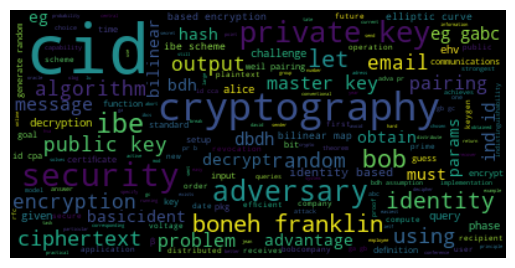

In [17]:
with open(f'article2.txt', "r", encoding='utf-8') as file:
    text = file.read()
text = pre_process_keywords(text)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")